### Importing Libraries

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

### Read and Check Data

In [2]:
df = pd.read_csv('Final Transactions.csv')
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB


In [4]:
df.isna().sum()

Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

### Understand and Analysis of Data

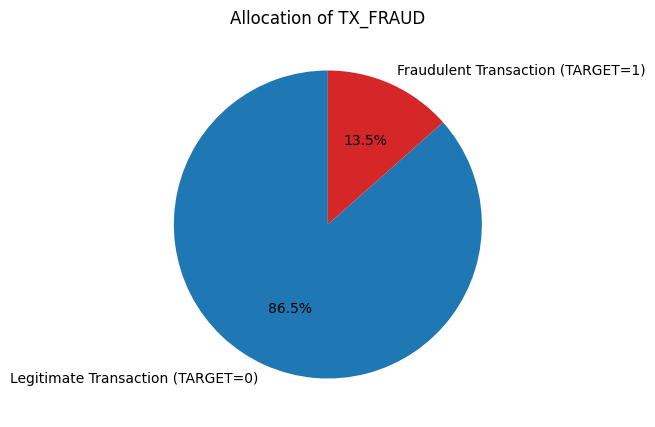

In [5]:
fraud_distribution = df['TX_FRAUD'].value_counts()

plt.figure(figsize=(5, 5))
fraud_distribution.plot.pie(
    labels=['Legitimate Transaction (TARGET=0)', 'Fraudulent Transaction (TARGET=1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#1f77b4', '#d62728']  
)
plt.title('Allocation of TX_FRAUD')
plt.ylabel('') 
plt.show()

Since the data is quite unbalanced, with 13.5% fraudulent transactions and 86.5% legitimate transactions, we use SMOTE (Synthetic Minority Oversampling Technique) to address the imbalance. 

However, before applying SMOTE, we split the data to prevent oversampling from affecting the validation dataset, ensuring the model is evaluated on real, unaltered data.

### Preprocessing Data

In [6]:
CATEGORICAL_COLUMNS = ['CUSTOMER_ID', 'TERMINAL_ID']
NUMERIC_COLUMNS = ['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']

In [7]:
X = df[CATEGORICAL_COLUMNS + NUMERIC_COLUMNS]
y = df['TX_FRAUD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), NUMERIC_COLUMNS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_COLUMNS)
    ]
)

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

In [9]:
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pre, y_train)

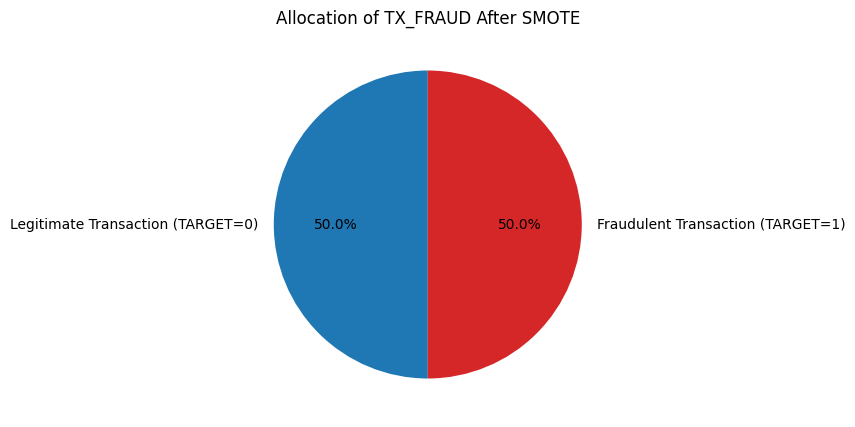

In [10]:
smote_resampled = y_train_resampled.value_counts()

plt.figure(figsize=(5, 5))
smote_resampled.plot.pie(
    labels=['Legitimate Transaction (TARGET=0)', 'Fraudulent Transaction (TARGET=1)'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#1f77b4', '#d62728']  
)
plt.title('Allocation of TX_FRAUD After SMOTE')
plt.ylabel('') 
plt.show()

### Modeling

In [11]:
nn_model = keras.Sequential([
    keras.layers.Input(shape=(X_train_resampled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
nn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = nn_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
print(history.history)

Epoch 1/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 155s 5ms/step - accuracy: 0.7969 - loss: 0.4095 - val_accuracy: 0.8476 - val_loss: 0.4164
Epoch 2/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.8551 - loss: 0.3184 - val_accuracy: 0.8854 - val_loss: 0.3325
Epoch 3/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accuracy: 0.8770 - loss: 0.2816 - val_accuracy: 0.9120 - val_loss: 0.2734
Epoch 4/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.8960 - loss: 0.2433 - val_accuracy: 0.9296 - val_loss: 0.1991
Epoch 5/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.9172 - loss: 0.1972 - val_accuracy: 0.9530 - val_loss: 0.1438
Epoch 6/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 148s 5ms/step - accuracy: 0.9289 - loss: 0.1730 - val_accuracy: 0.9650 - val_loss: 0.1080
Epoch 7/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - accuracy: 0.9369 - loss: 0.1554 - val_accuracy: 0.9724 - val_loss: 0.0879
Epoch 8/10
30364/30364 ━━━━━━━━━━━━━━━━━━━━ 147s 5ms/step - ac

### Results

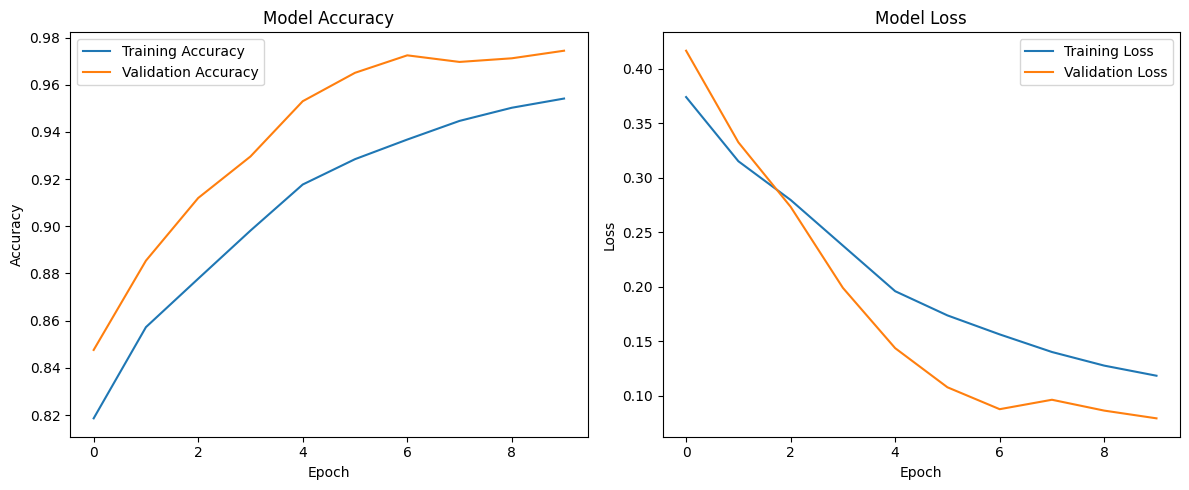

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

10964/10964 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


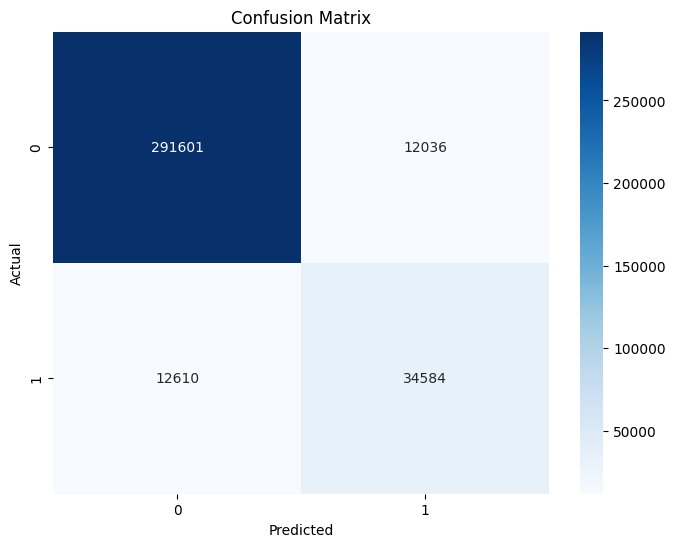

In [15]:
y_pred = nn_model.predict(X_test_pre)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
report = classification_report(y_test, y_pred_classes, target_names=['Legitimate Transaction (TARGET=0)', 'Fraudulent Transaction (TARGET=1)'])
print(report)

                                   precision    recall  f1-score   support

Legitimate Transaction (TARGET=0)       0.96      0.96      0.96    303637
Fraudulent Transaction (TARGET=1)       0.74      0.73      0.74     47194

                         accuracy                           0.93    350831
                        macro avg       0.85      0.85      0.85    350831
                     weighted avg       0.93      0.93      0.93    350831

